In [2]:
import sys, os, glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.io as io 

import models.rdmpy.calibrate as calibrate

import models.forward as forward
import dataset.preprocess_data as prep_data
import utils.psf_utils as psf_utils
import utils.diffuser_utils as diffuser_utils
import utils.helper_functions as helper

device = "cuda:0"
%load_ext autoreload
%autoreload 2

## PSF calibration
To perform spatially varying deconvolution, we need spatially varying PSFs. We can generate PSFs for every point in the system by estimating the seidel coefficients of the lens, and generating PSF data for each point based off of these coefficients.

We will use the `rdmpy.calibrate.calibrate()` method to estimate coefficients based off of our superimposed psf measurements.

### Calculating the alignment axis
To estimate the alignment axis, we note that field curvature in the system induces barrel distortion sampled as we translate our sensor through the image plane. The result is radial translation of the center of our PSF at different levels of focus. We can leverage this translation to estimate the alignment axis. For more information see [psf_calibration_utils.py](./utils/psf_calibration_utils.py).

Notice that a cluster will form near the estimate. A "good" estimate is one with a clustered distribution. Consider using different estimation and coordinate localizing methods, or changing which two focus levels you are comparing.

In [1]:
psf_path = "../defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/10_26/multipos/alignment_psfs_telecent25um_10_26"

crop = (400,0,1500,1000) # crop down to the general psf location to reduce computation
blur_levels = 3 # levels of focus in your measurements
estimate_method = "median" # mean if your points seem to shift very consistently, median if they dont
coord_method = "conv" # method for estimating psf coordinates. Note "conv" may outperform but is slower
anchor_idx = 1 # index of first focus to draw vector from
delta_idx = 2 # index of second focus to draw vector through
conv_kern_sizes = [7, 21, 45] # approximate psf sizes, used as kernel size in convolution


# Note: a "good" estimate is one with a clustered distribution
alignment_estimate = psf_utils.estimate_alignment_center(
    psf_path, 
    blur_levels,
    estimate_method=estimate_method, 
    coord_method=coord_method, 
    anchor_foc_idx=anchor_idx,
    vector_foc_idx=delta_idx,
    conv_kern_sizes=conv_kern_sizes,
    crop = crop,
    verbose=True,
    plot=True
)

NameError: name 'psf_utils' is not defined

### Experimental calibration
Instead of using seidel fitting to generate simulate psfs, we will use actual psf measurements, and rotate them around a known alignment axis to generate a "real" LRI psf stack. The following cells give an example of this.

In [5]:
############### Hyperparameters ################
psf_path = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/multipos/alignment_psfs_telecent25um_5_blur"
blur_levels = 5
crop_size = 768 # a crop of this size must contain ALL of the measurements
dim = 256 # output image size (to downsample to)
alignment_estimate = (1000, 472) # system alignment center

coord_method = "conv" # method for estimating psf coordinates. Note "conv" may outperform but is slower
ksizes = [7, 21, 45, 55, 65] # kernel sizes (for conv point finding)
min_distance = 25 # minimum distance between psfs (for peaks point finding)
exposures = [1 / 662, 1 / 110, 1 / 45, 1 / 30, 1 / 21] # exposures of each focus level (IMPORTANT)
threshold = 0.7 # quantile value thresholding for psfs
psf_dim = 120 # maximum size of largest psf (in output space pixels)
polar = True # whether to return a polar or real psf stack
interpolate_ramp = True # whether to interpolate between psfs

Reading psf: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s]

Scaled psfs by values: [1.0, 0.1661631419939577, 0.06797583081570997, 0.045317220543806644, 0.03172205438066465]
Centering:  64%|██████▍   | 16/25 [00:00<00:00, 158.22it/s]

Centering: 100%|██████████| 25/25 [00:00<00:00, 158.99it/s]


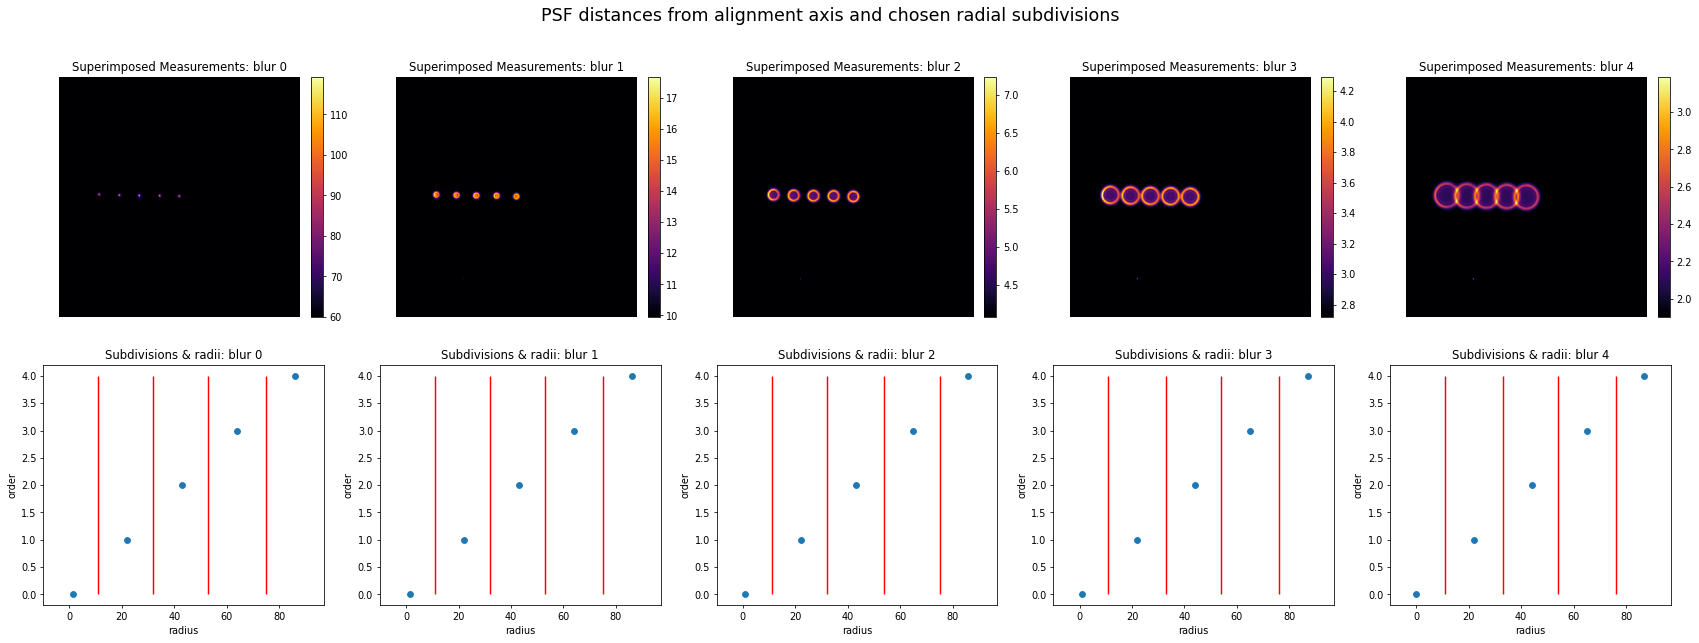

Interpolating: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

Rendering 1/5:
 20%|█▉        | 50/256 [00:00<00:00, 493.35it/s]

100%|██████████| 256/256 [00:00<00:00, 408.82it/s]
Rendering 2/5:
100%|██████████| 256/256 [00:00<00:00, 426.29it/s]
Rendering 3/5:
100%|██████████| 256/256 [00:00<00:00, 414.24it/s]
Rendering 4/5:
100%|██████████| 256/256 [00:00<00:00, 391.66it/s]
Rendering 5/5:
100%|██████████| 256/256 [00:00<00:00, 388.83it/s]

Rendering rings:   0%|          | 0/5 [00:00<?, ?it/s]

Rendering rings: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]


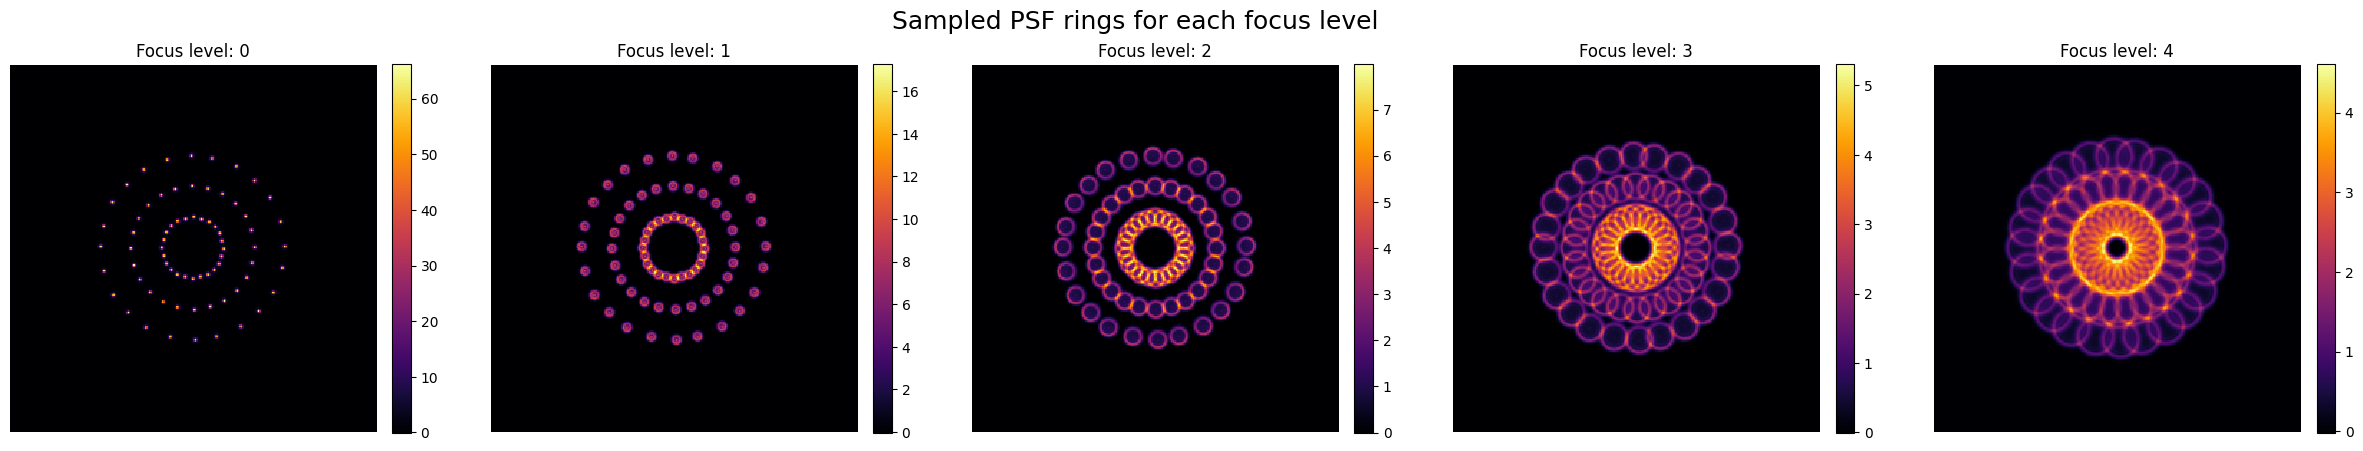

Computing RoFTs: 100%|██████████| 5/5 [00:00<00:00, 4709.53it/s]


In [7]:
psf_data = psf_utils.get_lri_psfs(
    psf_dir=psf_path,
    blur_levels=blur_levels,
    crop_size=crop_size,
    dim=dim,
    alignment_estimate=alignment_estimate,
    coord_method=coord_method,
    ksizes=ksizes,
    min_distance=min_distance,
    exposures=exposures,
    threshold=threshold,
    psf_dim=psf_dim,
    polar=polar,
    use_psf_ramp=interpolate_ramp,
    device=device,
    verbose=True,
    plot=True,
)

The ideal subdivision plot here should be a linear relationship. We should also see that the radial subdivision (shown by the **red lines**) should fall evenly between our found radii. 

Notice that as blur *increases*, the plots get *less* consistent. This is because the psf center-finding algorithm begins to fail as the psfs get very large and start to deform. For this reason we choose the radii from the most in-focus point to set our subdivisions.

Below we will see what the polar RoFT data looks like. Notice that the width of the data increases as the psf width increases. This is because a wide PSF spreads information across many angles.

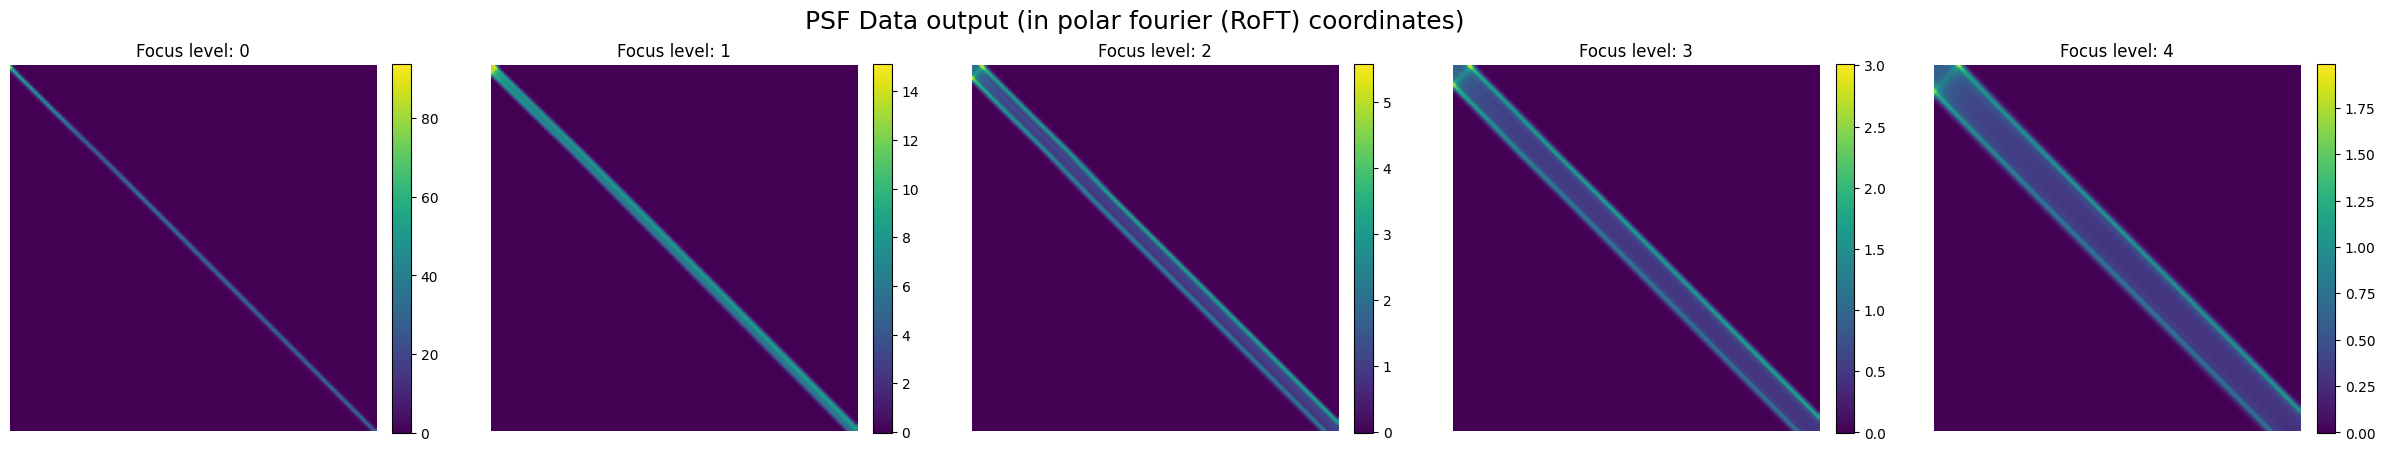

In [8]:
fig, ax = plt.subplots(1, blur_levels, figsize=(blur_levels * 6, 5), dpi=100)
for i in range(blur_levels):
    if polar:
        img = ax[i].imshow(np.mean(np.real(psf_data[i, ...]), axis=1))
    else:
        img = ax[i].imshow(np.sum(psf_data[i, ::30, :, :], axis=0))
    fig.colorbar(img, ax=ax[i], fraction=0.046, pad=0.04)
    ax[i].set_title(f"Focus level: {i}")
    ax[i].axis('off')

plt.suptitle(f"PSF Data output (in {'polar fourier (RoFT)' if polar else 'real space'} coordinates)", fontsize=18)
plt.show()

In [82]:
for i in range(psf_data.shape[0]):
    psf_utils.save_lri_psf(torch.zeros(1), torch.tensor(psf_data[i]), os.path.join(psf_path, "dim768-256_5focus"), i)

Saved psf data of shape (256, 513, 256) to /home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/multipos/alignment_psfs_cross_5_blur/dim768-256_5focus/lri_psf_calib_0.mat.
Saved psf data of shape (256, 513, 256) to /home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/multipos/alignment_psfs_cross_5_blur/dim768-256_5focus/lri_psf_calib_1.mat.
Saved psf data of shape (256, 513, 256) to /home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/multipos/alignment_psfs_cross_5_blur/dim768-256_5focus/lri_psf_calib_2.mat.
Saved psf data of shape (256, 513, 256) to /home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/multipos/alignment_psfs_cross_5_blur/dim768-256_5focus/lri_psf_calib_3.mat.
Saved psf data of shape (256, 513, 256) to /home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/multipos/alignment_ps

## Image transformation: simulating spatially varying convolution
Our typical [forward model](./models/forward.py) approximates a linear spatially invariant (LSI) system by performing a standard convolution with the input at each level of defocus. 

As an initial reconstruction step, we consider the adjoint of our system. Our LSI forward model is:

$$\mathbf b_i = \sum_{\lambda=0}^{K-1} \mathbf M_{\lambda}[x,y] \cdot  \text{crop} \Big( \mathbf h_i[x,y,\lambda] \stackrel{[x,y]}{*} \mathbf v[x,y,\lambda] \Big) = \mathbf A_i \mathbf v$$

and the adjoint is found as:

$$ \hat{\mathbf{v}}_i = \mathbf{h}_i^* \stackrel{[x,y]}{*} \text{pad}(\mathbf{M}_\lambda [x,y] \cdot \mathbf{b}_i) = \mathbf{A}_i^H\mathbf b_i$$

For an LRI system, the assumption changes, and we must now perform a LRI convolution (denoted here as $\odot$) between our spatially varying psf data $\tilde{\mathbf h}$ and our image:

$$\mathbf b_i = \sum_{\lambda=0}^{K-1} \mathbf M_{\lambda}[x,y] \cdot  \text{crop} \Big( \tilde{\mathbf h_i}[\rho,\theta] \stackrel{[\rho, \theta]}\odot \mathbf v[\rho,\theta,\lambda] \Big) = \tilde{\mathbf A_i} \mathbf v$$

Where $i$ denotes the focus level. But, given that the spatially varying convolution with a spatially varying $\tilde{\mathbf h}$ can, like a uniform convolution with a LSI $\mathbf h$, be written as matrix operations $\tilde{\mathbf A}$ and $\mathbf A$ (respectively), the adjoint of this system is also found as:

$$ \hat{\mathbf v_i} = \tilde{\mathbf h_i}^* \stackrel{[\rho,\theta]} \odot \text{pad}(\mathbf{M}_\lambda [x,y] \cdot \mathbf{b}_i) = \tilde{\mathbf A_i}^H\mathbf b_i$$


### Data preprocessing
First we must preprocess our data into a usable form. We use three datasets - [Harvards hyperspectral dataset](http://vision.seas.harvard.edu/hyperspec/), [Pavia Centre and University](https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes), and the [Geissen Fruit Dataset](https://zenodo.org/record/2611806).

Note that this may take a while, as some of the data is quite large.
We will guide the hyperparameters of the rest of this notebook with a config file. Templates can be found [here](config_files/TEMPLATE_training.yml).

In [3]:
config_path = "/home/cfoley_waller/defocam/SpectralDefocusCam/config_files/training/train_11_21_2023_lri_precomputed_real_psfs.yml"
config = helper.read_config(config_path)
config["data_precomputed"] = False
processed_datapath = config["base_data_path"]
print(processed_datapath)

/home/cfoley_waller/defocam/defocuscamdata/sample_data_preprocessed_lri_11_22


In [4]:
raw_datapath = "/home/cfoley_waller/10tb_extension/defocam/defocuscamdata/sample_data/"

patchsize = config["patch_size"] # size of patches to chunk data - factor of cropsize for best results
num_channels = 30 # channels are linearly interpolated to fit this value from raw data - note same issue as above
prep_data.preprocess_harvard_data(os.path.join(raw_datapath, "harvard"), os.path.join(processed_datapath, "harvard_data"), patchsize, num_channels)
prep_data.preprocess_pavia_data(os.path.join(raw_datapath, "paviadata"), os.path.join(processed_datapath, "pavia_data"), patchsize, num_channels)
prep_data.preprocess_fruit_data(os.path.join(raw_datapath, "fruitdata/pca"), os.path.join(processed_datapath, "fruit_data"), patchsize, num_channels)

Preprocessing Fruit Data: 100%|██████████| 42/42 [03:23<00:00,  4.85s/it]


It is important to view the false-color projections and spectral responses of this processed data. The following code cells will generate interactive plots to analyze the spectral responses of our hyperspectral data. Click in the images to find the response at that pixel.

Notice that the false color projection uses the CIE 1931 2 Degree Standard Observer color matching functions, which may not match the specifics of each dataset. We attempt to fix this matching by specifying the original range of the data

In [53]:
img_index = 1 # number from 0 to 2
harvard_data, pavia_data, fruit_data = [], [], []
for i in range(2):
    harvard_data.append(io.loadmat(glob.glob(os.path.join(processed_datapath, "harvard_data","*.mat"))[i])['image'])
    pavia_data.append(io.loadmat(glob.glob(os.path.join(processed_datapath, "pavia_data","*.mat"))[i])['image'])
    fruit_data.append(io.loadmat(glob.glob(os.path.join(processed_datapath, "fruit_data","*.mat"))[i])['image'])

In [54]:
helper.plot_cube_interactive(harvard_data[img_index], fc_range=[420, 720])


FigureWidget({
    'data': [{'type': 'image',
              'uid': '843be09f-07f5-4e90-a229-a43a98477c82',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 18,  16,  22],
                           [ 17,  16,  22],
                           [ 16,  15,  21],
                           ..., 
                           [ 72,  84,  84],
                           [ 63,  72,  63],
                           [ 50,  57,  49]],
                   
                          [[ 18,  16,  23],
                           [ 19,  17,  26],
                           [ 18,  16,  23],
                           ..., 
                           [ 90, 105, 112],
                           [ 83,  96,  94],
                           [ 55,  63,  57]],
                   
                          [[ 20,  19,  28],
                           [ 21,  21,  27],
                           [ 21,  21,  32],
                           ..., 
                           [100, 114

In [21]:
helper.plot_cube_interactive(pavia_data[img_index], fc_range=[430,860])

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'b8dd99cb-2ec1-4ba6-b448-0df73fc73574',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[55, 50, 29],
                           [56, 52, 28],
                           [52, 48, 29],
                           ..., 
                           [ 1,  0,  3],
                           [ 1,  0,  5],
                           [ 1,  1,  4]],
                   
                          [[55, 50, 29],
                           [55, 51, 31],
                           [39, 37, 28],
                           ..., 
                           [ 2,  1,  5],
                           [ 2,  1,  6],
                           [ 1,  1,  6]],
                   
                          [[52, 48, 28],
                           [51, 46, 30],
                           [28, 27, 21],
                           ..., 
                           [ 3,  2,  8],
                           [ 2,  2,  6],

In [20]:
helper.plot_cube_interactive(fruit_data[img_index], fc_range=[376,821])

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'f52b28b7-2b41-4caa-a64d-4c5cd5df0d1b',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[164, 166, 152],
                           [164, 166, 147],
                           [163, 166, 148],
                           ..., 
                           [192, 196, 173],
                           [190, 194, 173],
                           [187, 191, 170]],
                   
                          [[160, 162, 150],
                           [163, 167, 149],
                           [162, 164, 150],
                           ..., 
                           [191, 195, 171],
                           [190, 193, 170],
                           [187, 190, 167]],
                   
                          [[164, 168, 148],
                           [165, 169, 146],
                           [162, 166, 146],
                           ..., 
                           [191, 194

### Performing the forward and adjoint computations
Next we initialize our forward model, which uses our calibrated PSF data to perform a linear revolution-invariant (LRI) spatially varying convolution using the `rdmpy.blur.ring_convolve()` function via ring-convolution. This is incorperated into the `Hfor_varying()` and `Hadj_varying()` methods of our [forward model](models/forward.py).

In [84]:
config["data_precomputed"] = False

mask = diffuser_utils.load_mask(
    path=config["mask_dir"],
    patch_crop_center=config["image_center"],
    patch_crop_size=config["patch_crop"],
    patch_size=config["patch_size"],
)
forward_model = forward.ForwardModel(mask, config["forward_model_params"], config["psf_dir"], device=device)
forward_model.init_psfs()

# The following should show whether we are using a varying or invariant Hfor and Hadj
print(forward_model.fwd, forward_model.adj)

<bound method ForwardModel.Hfor_varying of ForwardModel()> <bound method ForwardModel.Hadj_varying of ForwardModel()>


In [23]:
helper.plot_cube_interactive(mask, fc_range=[450, 810])

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'c5c7574c-6d27-48a6-9a2e-7ac25f82bdec',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 32,  48, 190],
                           [ 30,  44, 175],
                           [ 15,  22,  75],
                           ..., 
                           [  8,  10,   8],
                           [ 12,  17,   7],
                           [ 41,  76,  11]],
                   
                          [[ 25,  75, 154],
                           [ 23,  67, 134],
                           [ 13,  29,  63],
                           ..., 
                           [  8,  10,   8],
                           [ 12,  16,   7],
                           [ 40,  72,  11]],
                   
                          [[ 26,  69, 157],
                           [ 24,  62, 140],
                           [ 14,  28,  66],
                           ..., 
                           [ 10,   8

In [85]:
# If data pair generation needs to be rerun, uncomment this code
for dir in os.listdir(config["base_data_path"]):
    clean_dir = os.path.join(config["base_data_path"], dir)
    diffuser_utils.process_mat_files(clean_dir, clean_dir, overwrite=True)

 54%|█████▎    | 358/667 [00:12<00:12, 23.82it/s]

100%|██████████| 667/667 [00:24<00:00, 27.53it/s]


We can now use our forward model to build supervised learning pairs for each of our data samples. Doing this statically should drastically reduce training time, as the computation necessary to simulate our data is only done *once*, here.

**Note**: each simulated measurement stack is stored with the ground truth patch in its `.mat` file under a key defined by our forward model's params.

In [88]:
forward.build_data_pairs(os.path.join(config["base_data_path"], "harvard_data"), forward_model, batchsize=8)
forward.build_data_pairs(os.path.join(config["base_data_path"], "pavia_data"), forward_model, batchsize=8)
forward.build_data_pairs(os.path.join(config["base_data_path"], "fruit_data"), forward_model, batchsize=8)

Generating Pair harvard_data:   0%|          | 0/667 [00:00<?, ?it/s]

Generating Pair fruit_data: 100%|██████████| 38/38 [00:20<00:00,  1.84it/s]


Just to get an idea of what we were doing doing, we can look at the models output from the last step.

torch.Size([5, 256, 513, 256])


<ipython-input-87-6b008bc38664>:8: UserWarning:

Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:250.)



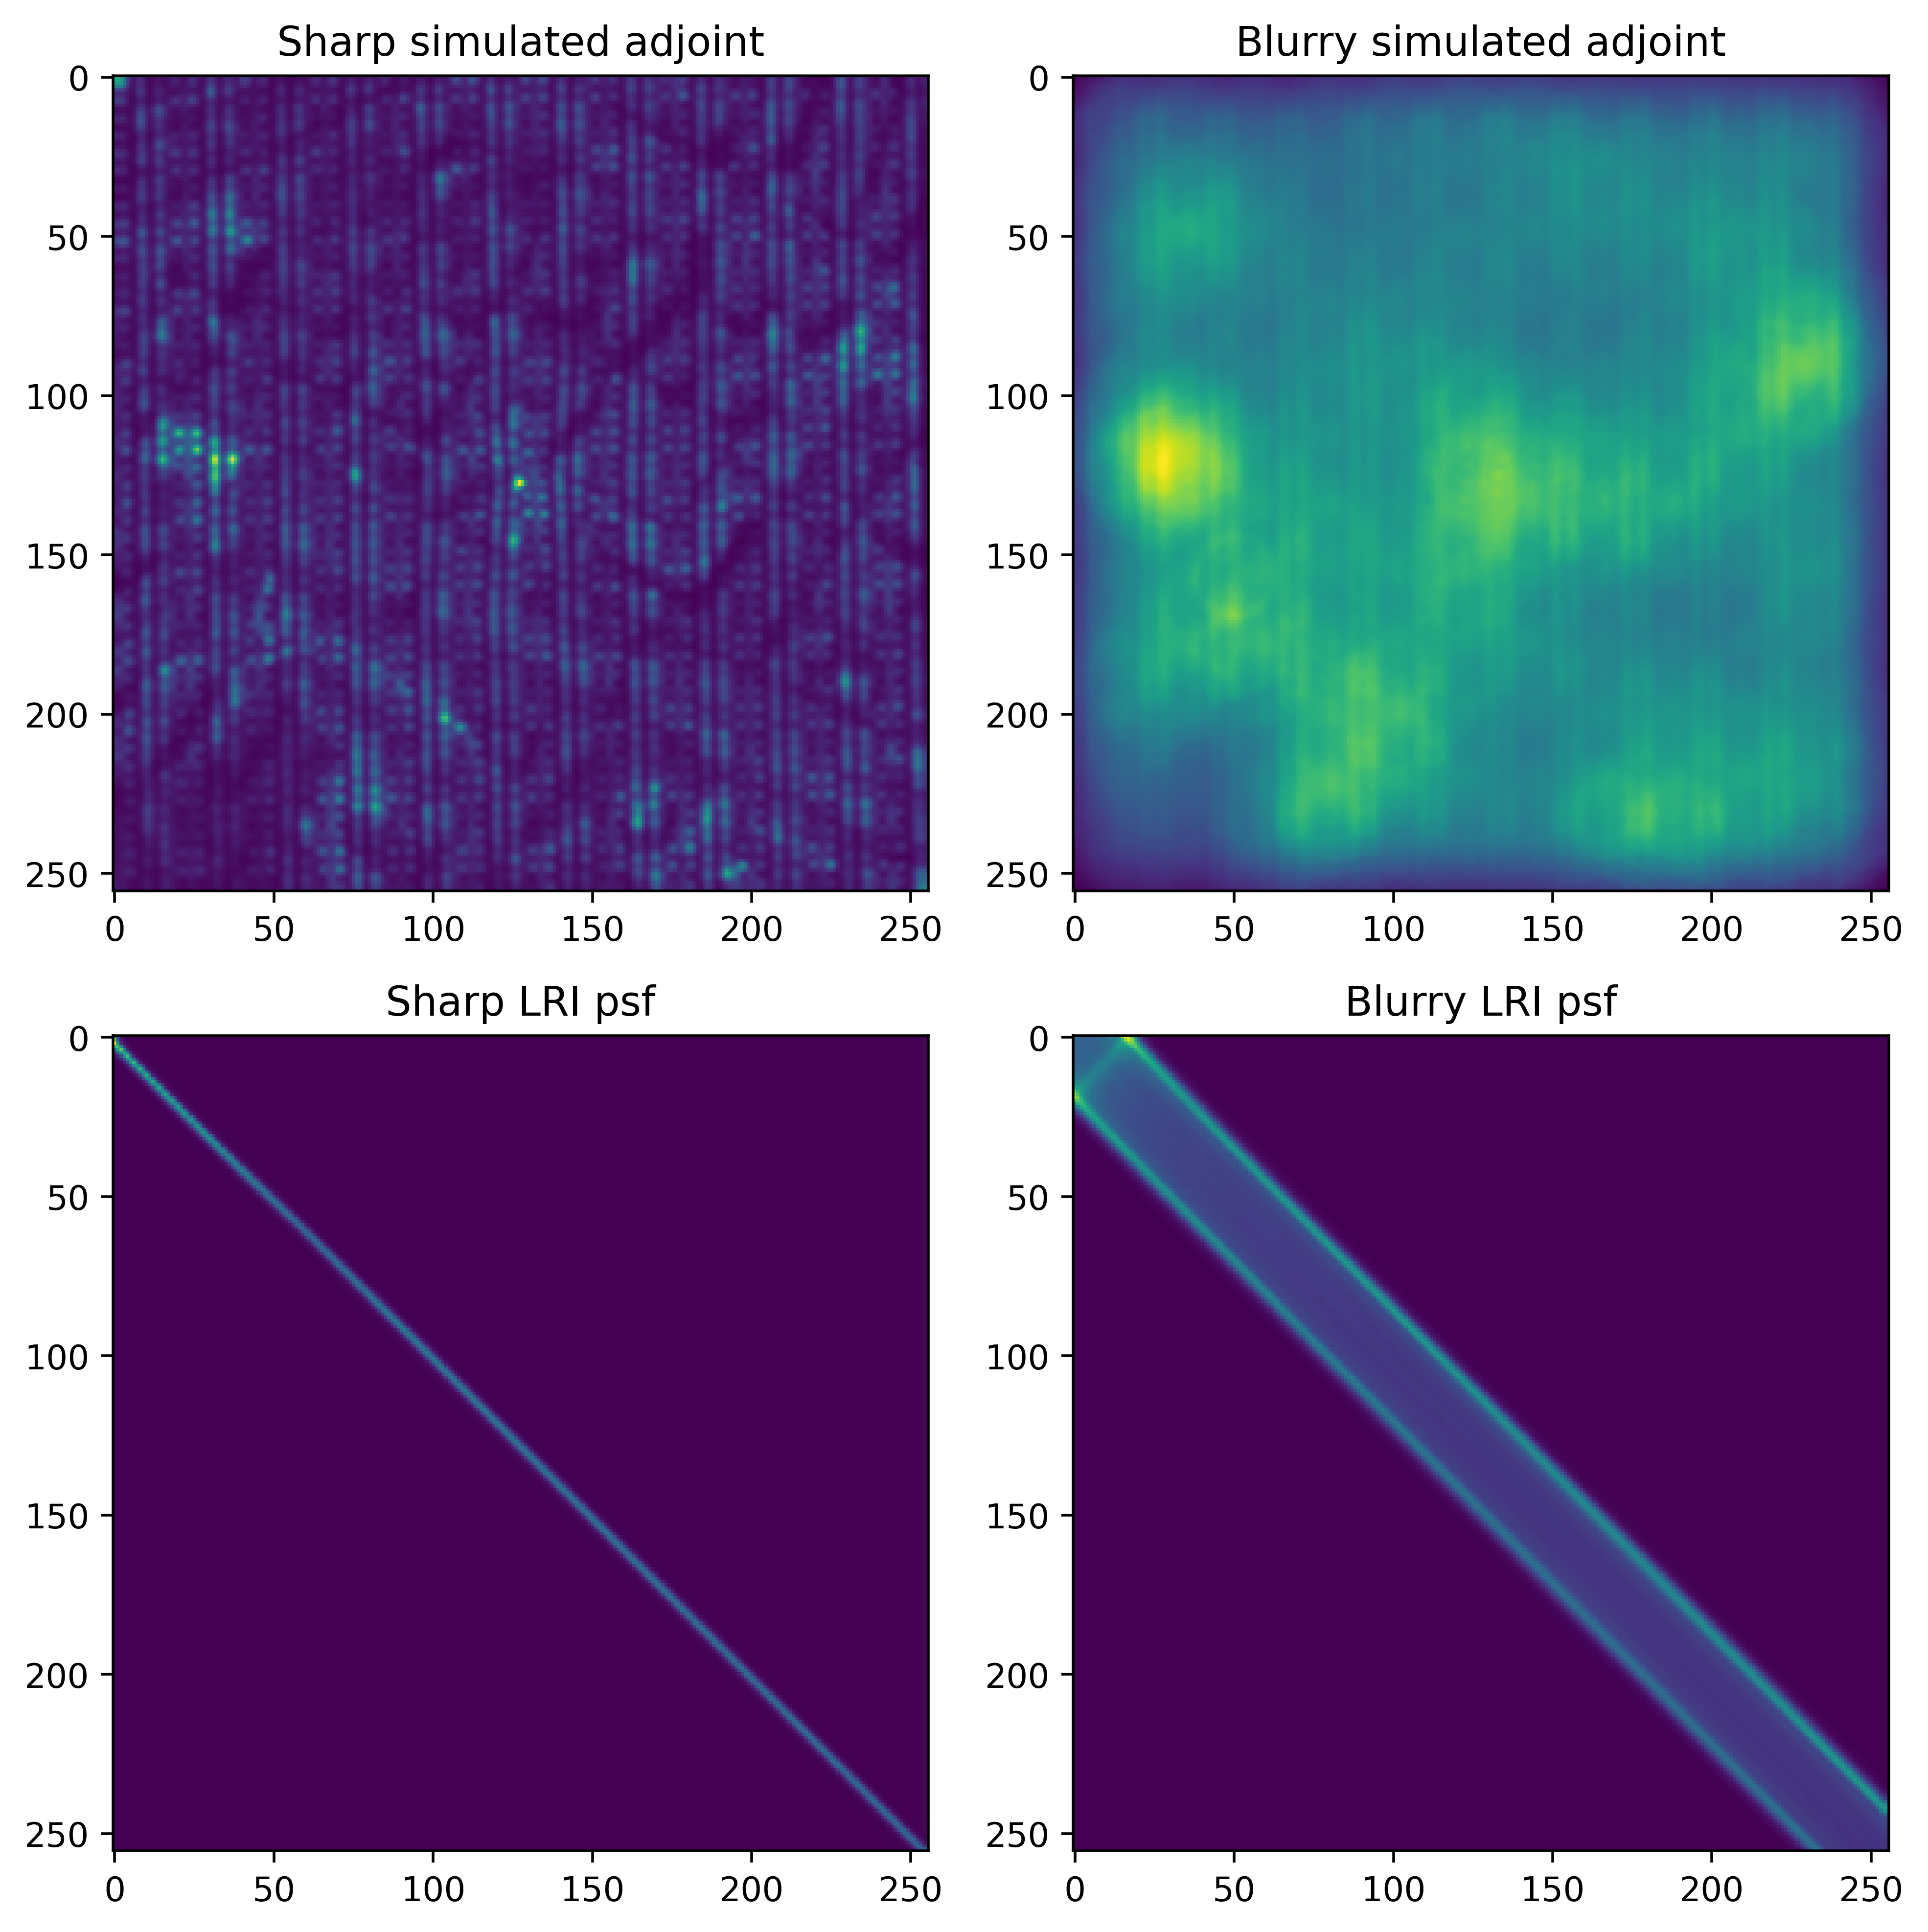

In [87]:
output, psf_data = forward_model.b, forward_model.psfs
print(psf_data.shape)
fig, ax = plt.subplots(2,2, figsize = (8,8))
ax[0,0].imshow(np.mean(output.detach().cpu().numpy()[0,0], 0))
ax[0,0].set_title("Sharp simulated adjoint")
ax[0,1].imshow(np.mean(output.detach().cpu().numpy()[0,-1], 0))
ax[0,1].set_title("Blurry simulated adjoint")
ax[1,0].imshow(np.mean(psf_data.float().detach().cpu().numpy()[0], 1))
ax[1,0].set_title("Sharp LRI psf")
ax[1,1].imshow(np.mean(psf_data.float().detach().cpu().numpy()[-1], 1))
ax[1,1].set_title("Blurry LRI psf")
plt.tight_layout()
plt.show()

And we're done. You should now be able to use these data pairs to train a deep reconstruction model.